# Driver safety estimation
Pointer Telocation is a developer of telocation devices for cars, focusing on fleet management and MRM (Mobile Resource Management). 
In addition to speed and location, the devices are capable of emitting different events related to driver behavior, such as harsh turns, harsh acceleration and harsh braking.

The objective of this project is to estimate a specific driver's safety score, for various business scenarios. Additional use cases include driver identification, eco-scoring and theft detection by deviation from the routine driver behavior.

## Data understanding and preparation

#### Load packages and set display options for notebook

In [18]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

## Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format

### Exploratory data analysis
The data represents various events created by the in-car devices. Most of the events are system events and some are behavioral driver events.
We will have two different data frames: *dfRaw* will contain all event types, and *df* will contain only events relevant for analysis, such as behavioral events (harsh turns, accelerations etc.)

To read the data from file:

In [19]:
## read data from csv
dfRaw = pd.read_csv("dataset.csv",index_col='DriverId')
dfRaw['ts']= pd.to_datetime(dfRaw.ts)
print('Size of dataset: {}'.format(len(dfRaw)))

Size of dataset: 899611


#### Observe some rows

In [20]:
dfRaw.head(10)

,EventName,Latitude,Longitude,Speed km/h,ts
DriverId,,,,,
0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090
0,Distance Event,34.1882,-118.0873,47.0000,2017-11-01 00:00:46.330
0,Distance Event,34.1894,-118.0864,24.0000,2017-11-01 00:00:55.320
0,Timed Event,34.1888,-118.0861,35.0000,2017-11-01 00:01:02.770
0,Distance Event,34.1891,-118.0851,43.0000,2017-11-01 00:01:06.610


The dataset contains events of various types (behavioral or functional) stored in the *EventName* column, in addition to metadata such as the current location (*Latitude* and *Longitude* columns), *Speed  km/h* and time (*ts* column). *DriverId* is the unique identifier of a driver.

#### Time in which samples were collected

In [21]:
maxTime = dfRaw['ts'].max()
minTime = dfRaw['ts'].min()
print("Events were taken between " + str(minTime.date()) + " and " + str(maxTime.date()))

Events were taken between 2017-10-31 and 2017-11-18


#### Number of drivers

In [22]:
driverCount = len(dfRaw.index.value_counts())
print("Number of drivers: {}".format(driverCount))

Number of drivers: 89


#### Number of events per driver

In [23]:
import numpy as np

# First define eventsPerDriver - this should be your actual data
eventsPerDriver = np.array([10, 15, 20, 5, 8])  # Example data - replace with your actual data

# Then calculate the mean
mean_value = np.mean(eventsPerDriver).item()
print("Mean number of events per driver {:0.1f}".format(mean_value))

Mean number of events per driver 11.6


In [24]:
mean_value = np.mean(eventsPerDriver).item()  # .item() converts numpy type to Python scalar
print("Mean number of events per driver {:0.1f}".format(mean_value))

Mean number of events per driver 11.6


#### Events per subscriber - drill down
What is the distribution of events across subscribers?

In [25]:
import pandas as pd
eventsPerDriver = pd.DataFrame(eventsPerDriver, columns=['EventName_count'])
eventsPerDriver.sort_values(by='EventName_count', ascending=False, inplace=True)

In [26]:
eventsPerDriver = np.sort(eventsPerDriver)[::-1]  # Sort in descending order

In [27]:
eventsPerDriver = dfRaw.groupby('DriverId').agg({"EventName":"count"}).add_suffix('_count')

Text(0, 0.5, 'Number of drivers')

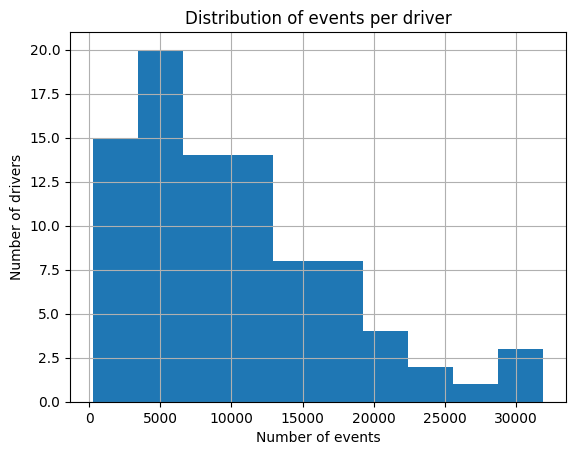

In [28]:
eventsPerDriver.sort_values(by='EventName_count',ascending = False,inplace = True)

eventsHist = eventsPerDriver['EventName_count'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

#### Events type
What kind of events are there? does looking at specific events change the distribution per driver?

<Axes: ylabel='EventName'>

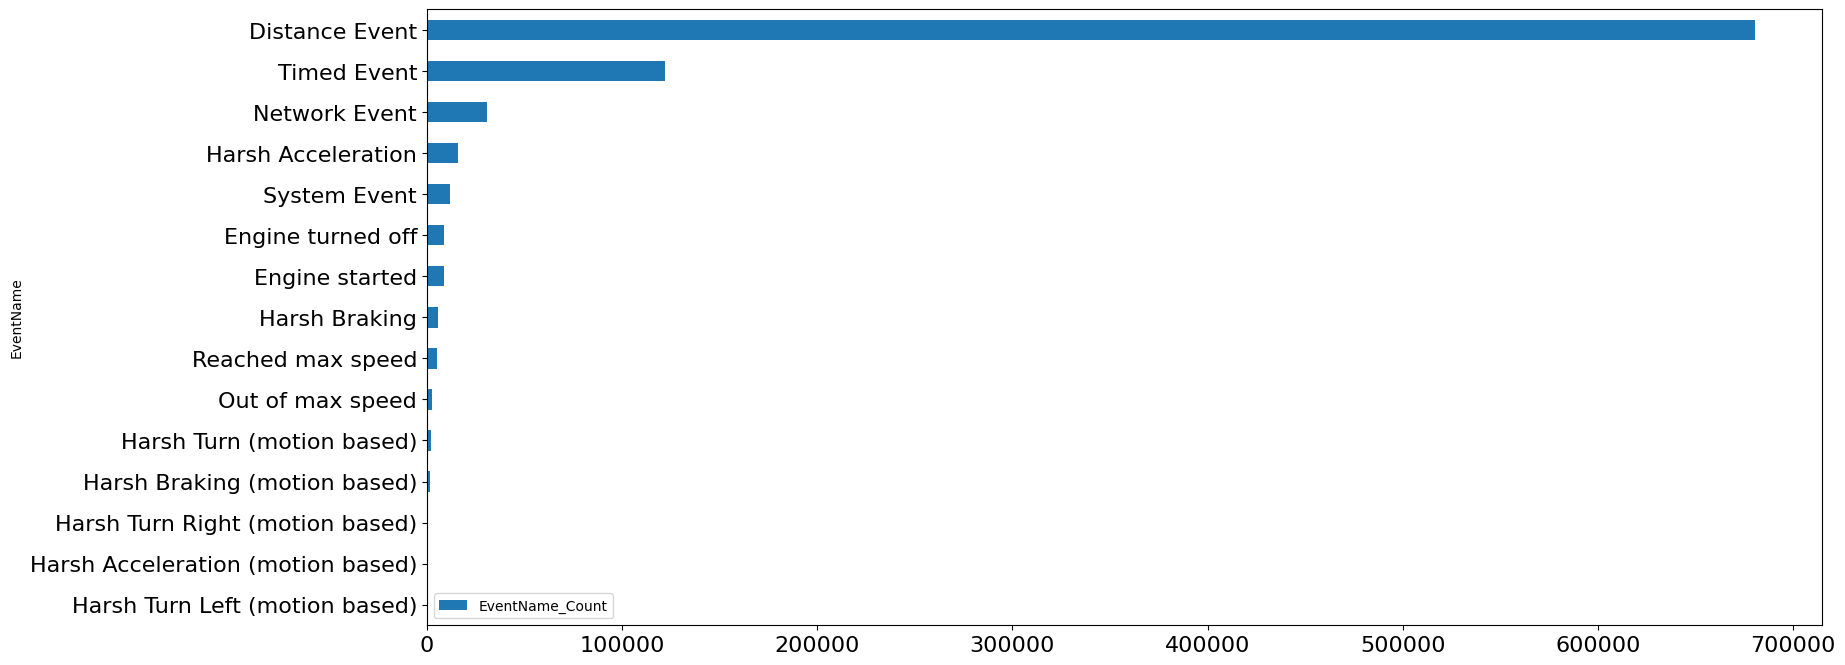

In [29]:
dfReasonHist = dfRaw.groupby(['EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,8),fontsize = 16)

Removing the Distance, Timed and Network events results in much less events:

In [30]:
events = [event for event in dfRaw.EventName if event not in ['Distance Event','Timed Event','Network Event','System Event']]
newCount = len(dfRaw[dfRaw['EventName'].isin(events)])
print("# of events before removing Distance Event, Timed Event, Network Event: {}, After removing: {}.\nReduction of {:0.2f} events. Current number of events: {}".format(len(dfRaw),newCount,(len(dfRaw) - newCount)/len(dfRaw),newCount))

# of events before removing Distance Event, Timed Event, Network Event: 899611, After removing: 54242.
Reduction of 0.94 events. Current number of events: 54242


#### Data prep
Remove non-behavioral events, remove drivers with too few samples and a few more cleanups

In [31]:
RELEVANT_EVENTS = ['Harsh Acceleration', 'Reached max speed', 'Out of max speed',
       'Harsh Braking', 'Harsh Turn (motion based)',
       'Harsh Braking (motion based)', 'Harsh Acceleration (motion based)',
       'Harsh Turn Left (motion based)', 'Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
  
    
    #Remove NAs
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    ## Filter out unwanted events
    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    
    ## Filter out users with too few samples
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    print("*** Done. ***")
    return(df)

df = prepData(dfRaw)

df.head()

*** Starting data prep. Length: 899611 ***
Removed NAs. Length: 899611
Keeping only events that are relevant for modeling. Length: 36468
Filtering users with too few samples. Length: 36262
*** Done. ***


,DriverId,EventName,Latitude,Longitude,Speed km/h,ts
41,0,Harsh Acceleration,34.1899,-118.0828,49.0000,2017-11-01 14:30:12.120
112,0,Reached max speed,34.1802,-118.1362,115.0000,2017-11-01 14:35:26.830
130,0,Out of max speed,34.1689,-118.1440,69.0000,2017-11-01 14:36:19.710
149,0,Harsh Braking,34.1591,-118.1414,98.0000,2017-11-01 14:38:01.930
186,0,Reached max speed,34.1375,-118.1473,122.0000,2017-11-01 14:39:59.440


#### Distribution of events per subscriber, while removing functional (non-behavioral) events

Text(0, 0.5, 'Number of drivers')

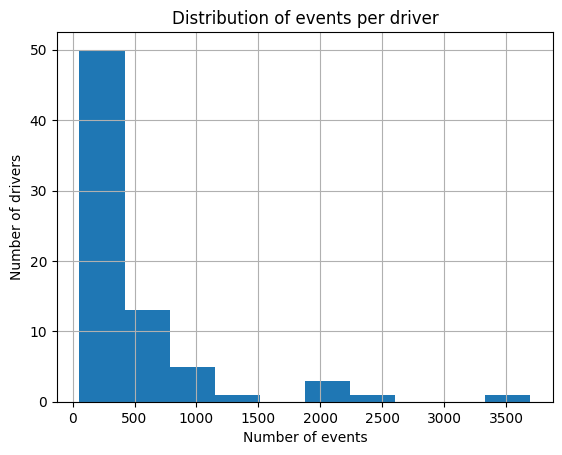

In [32]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

Types of events:

<Axes: ylabel='EventName'>

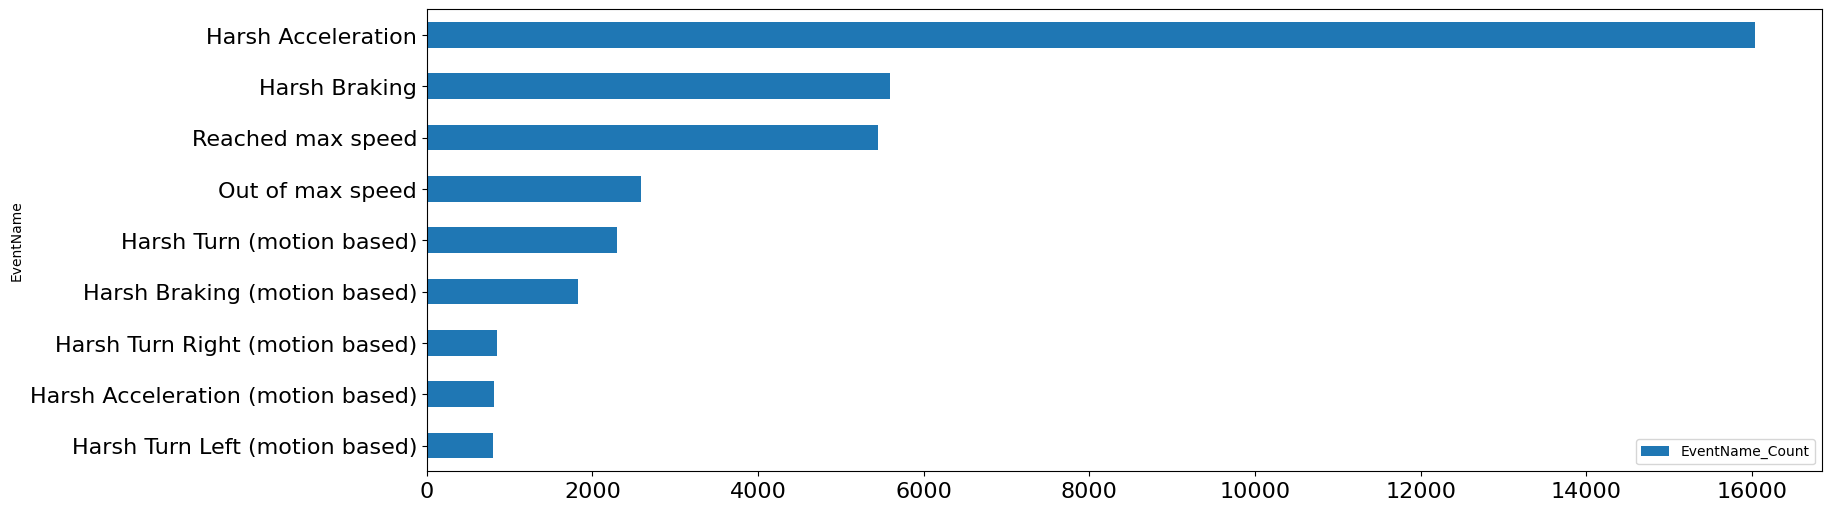

In [33]:
dfReasonHist = df.groupby('EventName')[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,6),fontsize = 16)

Some insights from this chart:
1. The number of high speed start events != number of events of end of high speed, which raises a red flag. In addition, the calculation could be inaccurate since it compares the current driver speed with a constant (e.g. 120 km/h) and not to the actual speed limit, so we will not be using it. The correct approach is to use an API that provides road segment max speed, and compare the driver's speed to the max speed. These APIs also have the option of snap-to-road which eliminated errors due to inaccurate GPS readings. For more info, see here: https://www.microsoft.com/en-us/maps/snap-to-road

2. There are multiple events that represent the same thing. For example, 'Harsh Acceleration' and 'Harsh Acceleration (motion based)'. This is due to different versions of the device, or to different sensors installed on different cars.

3. The motion based device has three values for harsh turning: Harsh Turn, Harsh Turn Left and Harsh Turn Right. We can further see that Harsh Turn Left + Harsh Turn Right != Harsh Turn. This is due to the time in which each event type was introduced into the system. We will use Harsh Turn and ignore the left and right values.

Since some drivers have more days of data on the system than others, looking at the absolute number of events isn't accurate. Instead, we'll normalize the number of events per driver by dividing by either total drive time or total distance.

In this code we calculate the total distance each driver had travelled:

In [34]:
## Calculate haversine distance (https://en.wikipedia.org/wiki/Haversine_formula)
## Code taken (and modified) from here: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def total_distance(oneDriver):
    dist = haversine(oneDriver.Longitude.shift(1), oneDriver.Latitude.shift(1),
                 oneDriver.loc[1:, 'Longitude'], oneDriver.loc[1:, 'Latitude'])
    return np.sum(dist)


## Calculate the overall distance made by each driver
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver.head(10)

C:\Users\HP\AppData\Local\Temp\ipykernel_15572\4114134117.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')


,DriverId,Distance
0,0,3761.7317
1,1,4317.0790
2,2,2509.1244
3,3,491.1896
4,4,1409.9199
5,5,5087.1414
6,6,1271.6811
7,7,2598.3032
8,8,4227.1878
9,9,906.6564


## Feature engineering
We define a feature set as the normalized number of events per type. For each behavioral event, we count the number of events and divide by total drive distance. For over-speeding, one can calculate the total amount of time each driver was over speeding, or some metric for the ratio between the current speed and the allowed maximum speed.

In [35]:
## Transform the events data frame to a features data frame (column for each type of relevant event)
def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index()

    
    ## Pivot events into columns
    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='EventName_Count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)

In [36]:
features.head()

,F_Harsh Acceleration,F_Harsh Acceleration (motion based),F_Harsh Braking,F_Harsh Braking (motion based),F_Harsh Turn (motion based),F_Harsh Turn Left (motion based),F_Harsh Turn Right (motion based),F_Out of max speed,F_Reached max speed
DriverId,,,,,,,,,
0,0.0747,0.0003,0.0231,0.0122,0.0069,0.0066,0.0040,0.0117,0.0154
1,0.0243,0.0002,0.0102,0.0021,0.0000,0.0025,0.0019,0.0153,0.0174
2,0.0769,0.0044,0.0275,0.0120,0.0052,0.0012,0.0000,0.0060,0.0104
4,0.0468,0.0000,0.0589,0.0206,0.0369,0.0262,0.0078,0.0099,0.0092
5,0.0627,0.0012,0.0147,0.0049,0.0177,0.0035,0.0092,0.0120,0.0204


Since there are two types of systems (motion based and not), we will look at one at a time and not join the two as the values and their proportions might be incomparable. In addition, we'll ignore the inaccurate over speeding event, as noted earlier. 

In [37]:
features = features.rename(columns={'F_Harsh Acceleration (motion based)': "Harsh Acceleration",
                                    'F_Harsh Braking (motion based)': "Harsh Braking",
                                   'F_Harsh Turn (motion based)':"Harsh Turning"},copy =False)
    
# select only motion based
features = features[['Harsh Acceleration','Harsh Braking','Harsh Turning']]

features.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0003,0.0122,0.0069
1,0.0002,0.0021,0.0000
2,0.0044,0.0120,0.0052
4,0.0000,0.0206,0.0369
5,0.0012,0.0049,0.0177


### Scatterplot matrix of features

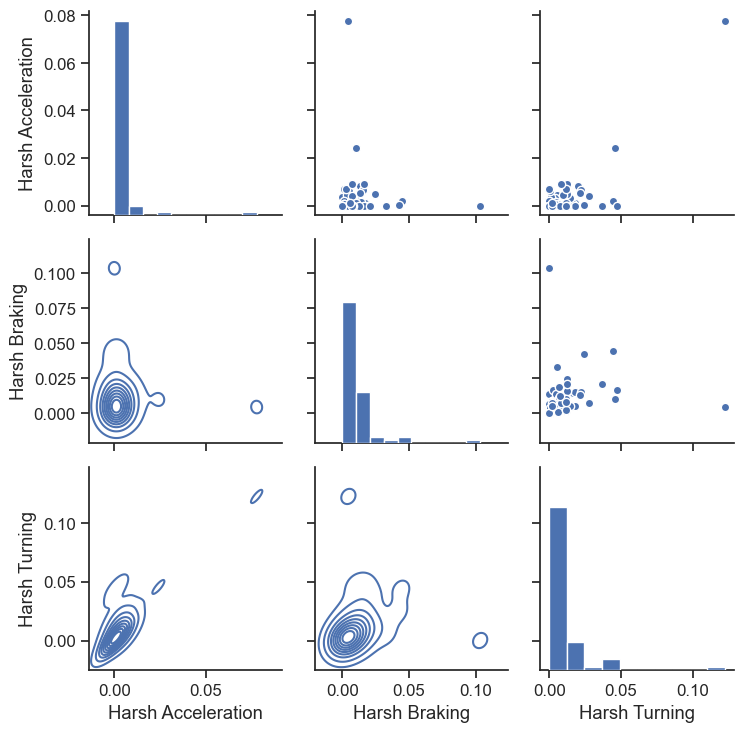

In [38]:
import seaborn as sns
sns.set(style="ticks",font_scale=1.1)
g = sns.PairGrid(features)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

All features are skewed to the right with a long tail. On the diagnoal, we see a histogram of all features. On the upper triangle we see a scatterplot of each pair of features, and on the bottom triangle we see a KDE (Kernel Density Estimation) of each pair of features

#### Example of a driver with many events of one type

In [39]:
features.loc[features['Harsh Turning'].idxmax(), ]

Harsh Acceleration   0.0778
Harsh Braking        0.0045
Harsh Turning        0.1226
Name: 51, dtype: float64

### Outliers handling
We wish to remove/adjust outliers as they affect many statistical approaches. In order to remove these, we'll transform the features to normal (using a box-cox transformation) and remove based on *mean + k*std's* rule. A second approach could be to truncate the tail using some constant, but it will be more difficult to find this threshold than the standard deviation rule. A third option is to remove outliers on all three dimensions (using a multivariate normal distribution, for example).

This code performs the first option, box-cox transformation:

In [40]:
import scipy.stats as st

def transform_to_normal(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal(x,min_max_transform = True)))
transFeatures.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0386,0.5650,0.3484
1,0.0337,0.1329,0.0000
2,0.4766,0.5569,0.2748
4,0.0000,0.7523,0.8953
5,0.1601,0.2851,0.6641


### Scatter plot matrix of transformed features

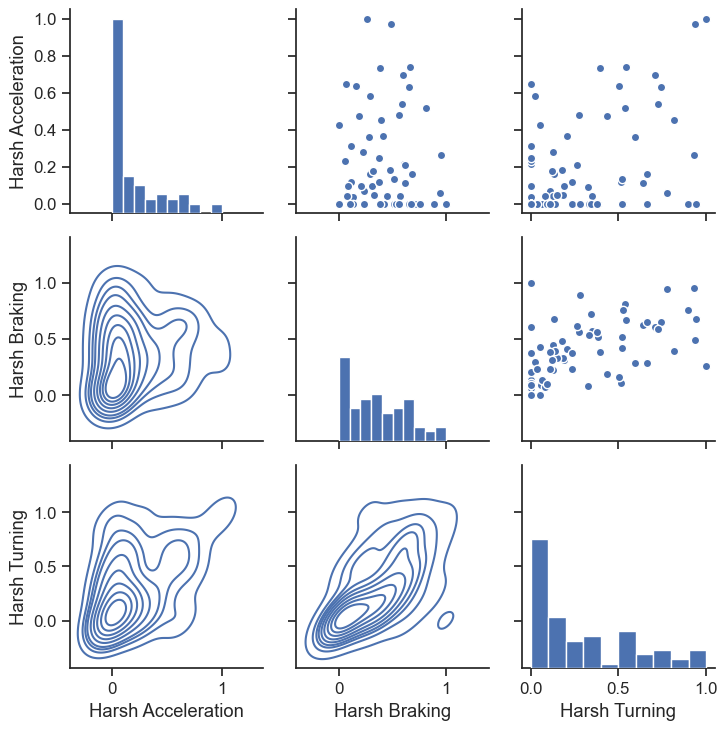

In [41]:
g = sns.PairGrid(transFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

You can see that the distribution is not symmetric yet, but not as skewed as the original data.
Let's use the mean + k std rule:

In [42]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor = 2.5, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal(x)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        #Normalize to [0,1]
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x)))
cleanFeatures.head(6)


Harsh Acceleration
found outlier with factor: 2.5 : [15 44]
replacing outliers [15 44] with max=0.00903159598449229
Harsh Braking
No outliers found
Harsh Turning
No outliers found


,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0003,0.0122,0.0069
1,0.0002,0.0021,0.0000
2,0.0044,0.0120,0.0052
3,0.0000,0.0206,0.0369
4,0.0012,0.0049,0.0177
5,0.0008,0.0142,0.0165


Outliers are found only on the harsh acceleration column

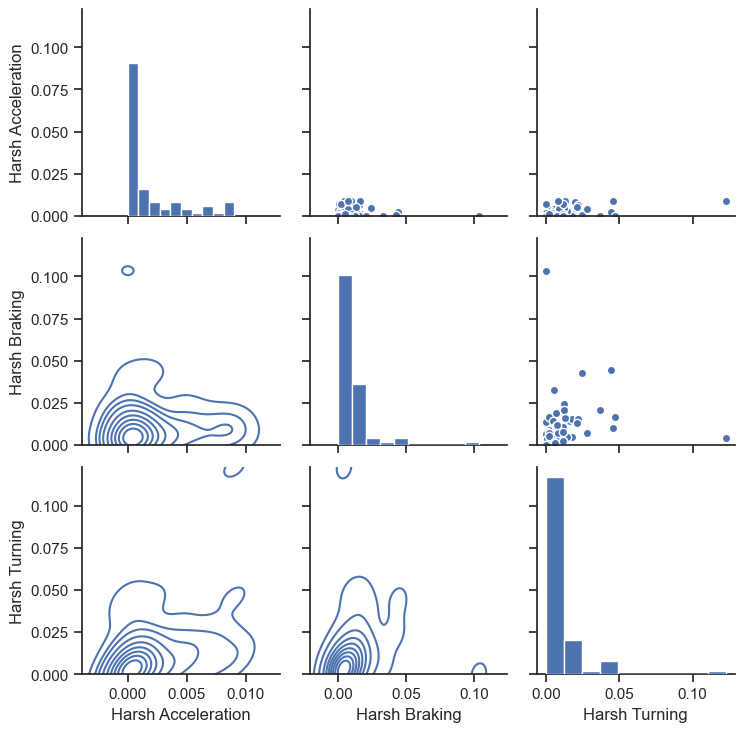

In [43]:
g = sns.PairGrid(cleanFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.set(ylim=((cleanFeatures.min().min()),(cleanFeatures.max().max())))

## Correlations between events

<Axes: >

<Figure size 640x480 with 0 Axes>

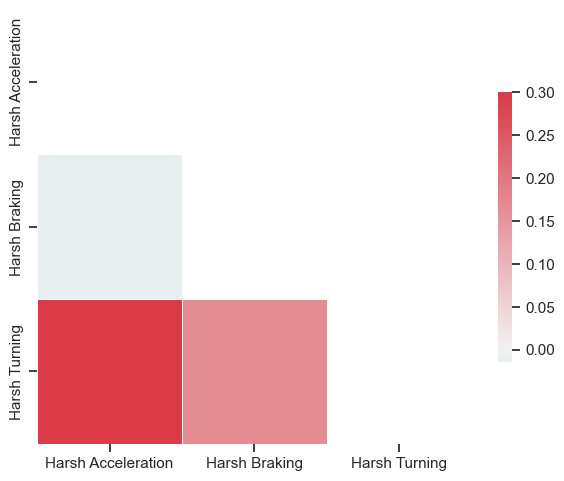

In [44]:
corr = cleanFeatures.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Modeling
#### Main hypothesis

Our main assumption while analyzing this data was that the more harsh events a driver had, the more likely he/she was to be an unsafe driver. A driver with zero harsh turns, zero harsh accelerations, zero over-speeding and zero harsh braking over some distance was more likely to be classified as a safe driver. On the contrary, we can assume that a driver who made multiple harsh movements over the same distance was an unsafe driver.

We used a number of different approaches for modeling:

- Modeling the problem as an anomaly detection problem or using some sort of clustering to find clusters of safe/unsafe drivers.
- Finding a multivariate metric that encompasses our assumption in multi dimensions and allowed us to estimate unsafe driving using probabilities over this multivariate distribution.
- Reducing the dimension to 1 and trying to find a rule/rank on this one unified metric.
    Using a univariate statistical model: modeling each event type individually by using statistical distributions.

In the following section we discuss how we evaluated different approaches for modeling this data.

In [45]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()


## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
Harsh Acceleration range:[0.0,0.00903159598449229]
Harsh Braking range:[0.0,0.10340548522686879]
Harsh Turning range:[0.0,0.12259498755008927]

Mean and STD before standardization
Harsh Acceleration range:[0.18775905104799828,0.255884198700874]
Harsh Braking range:[0.35563516077525426,0.2760560940159443]
Harsh Turning range:[0.28657741391892294,0.29888576889342505]


C:\Users\HP\AppData\Local\Temp\ipykernel_15572\3673336057.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))
C:\Users\HP\AppData\Local\Temp\ipykernel_15572\3673336057.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0294,0.1183,0.0564
1,0.0256,0.0202,0.0000
2,0.4854,0.1156,0.0423
3,0.0000,0.1989,0.3008
4,0.1306,0.0475,0.1443


### Anomaly detection:

The first approach we used was anomaly detection. We tried to see if we could highlight meaningful anomalies that might contain information about driver safety. A few approaches were evaluated, among them a method called HBOS and Local Outlier Factor (LOF). This plot shows the output of LOF on two dimensions of the dataset:

In [46]:
## LOF - Local Outlier Filter
from sklearn.neighbors import LocalOutlierFactor

X = transFeaturesScaled.values

clf = LocalOutlierFactor(n_neighbors=5)
isOutlier = clf.fit_predict(X)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


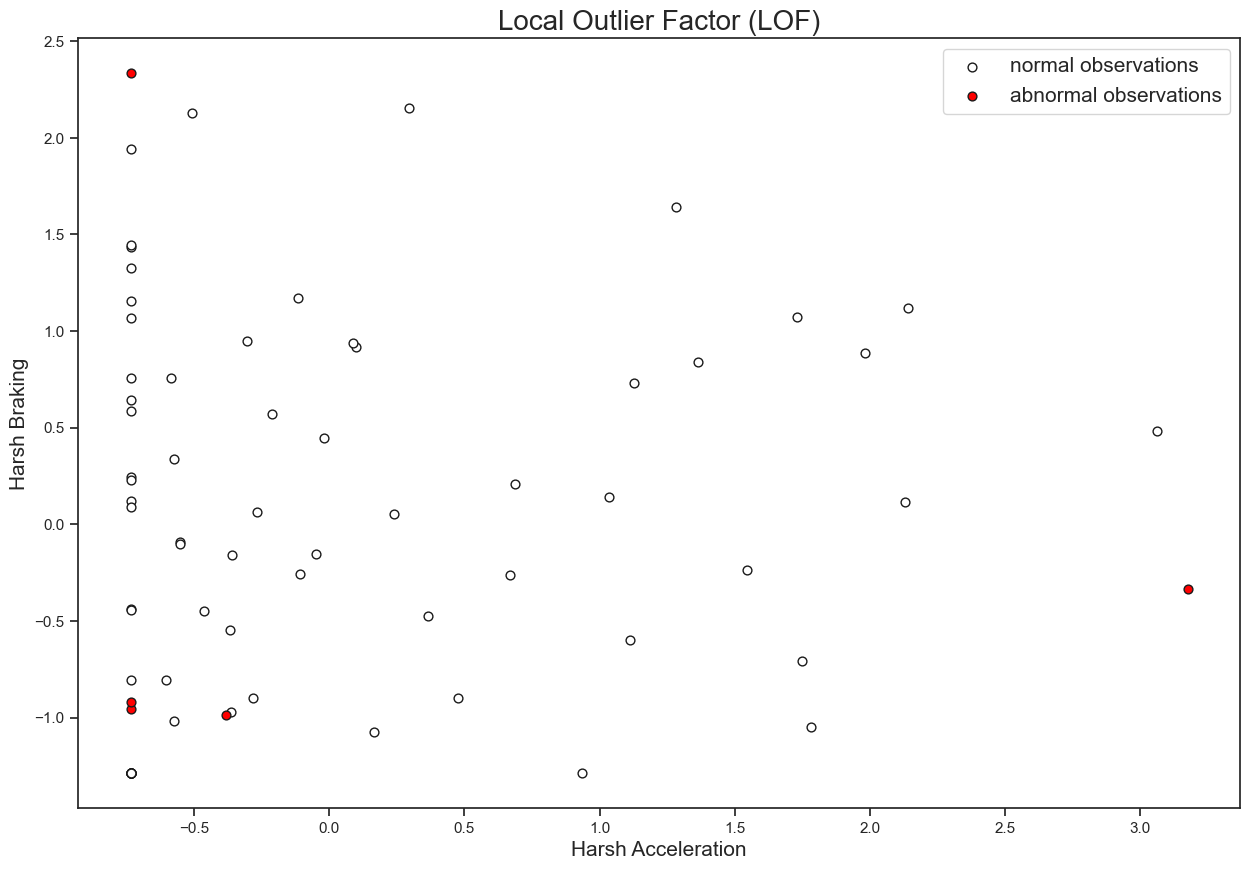

In [47]:
plt.title("Local Outlier Factor (LOF)",fontsize=20)


a = plt.scatter(X[isOutlier==1, 0], X[isOutlier==1, 1], c='white',
                edgecolor='k', s=40)
b = plt.scatter(X[isOutlier==-1, 0], X[isOutlier==-1, 1], c='red',
                edgecolor='k', s=40)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.xlabel(normalizedFeatures.columns[0],fontsize = 15)
plt.ylabel(normalizedFeatures.columns[1],fontsize = 15)
#plt.xlim((-0.01,1.01))
#plt.ylim((-0.01, 1.01))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper right",prop={'size': 15},frameon = True)
plt.show()

The LOF model looks for anomalous points in respect to each point's neighborhood. We ran LOF on all three dimensions, however this plot shows only the first two dimensions. Even after playing with the model's parameter (number of neighbors), we did not achieve meaningful results. It appears that statistical outliers did not imply behavioral outliers in this case.
### Multivariate analysis

The second approach was to find a multivariate representation of the distribution and then use it to calculate the probability of one driver being unsafe when compared to a general population of drivers. Essentially we look for drivers that lay on the tail of a multivariate right skewed distribution. We didn't pursue with this approach since most methods assume normal distribution, have other unmet assumptions, or do not have a robust implementation we could employ.
### Dimensionality reduction

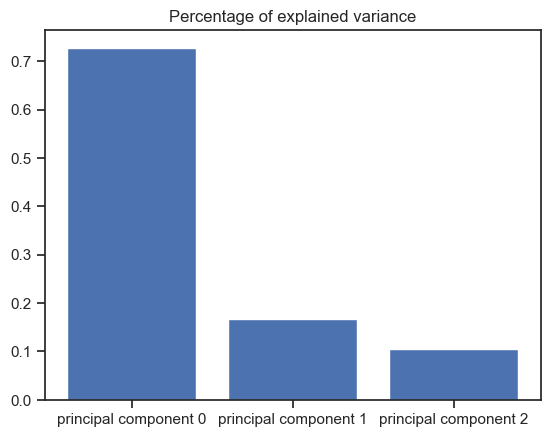

Pricipal components explained variance ratio: [0.7275472  0.16648689 0.10596592].


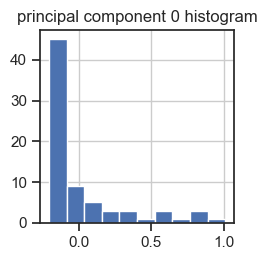

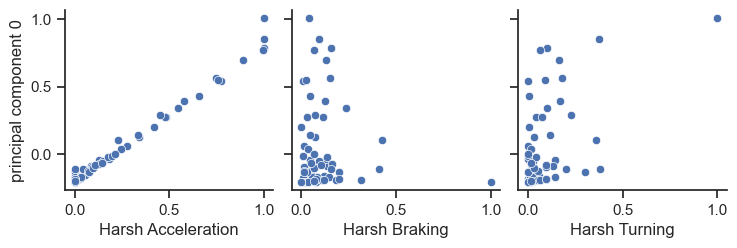

In [48]:
### PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(normalizedFeatures)
column_names = ['principal component {}'.format(i) for i in range(normalizedFeatures.shape[1])]


plt.bar(x = column_names,height = pca.explained_variance_ratio_)
plt.title("Percentage of explained variance")
plt.show()

print("Pricipal components explained variance ratio: {}.".format(pca.explained_variance_ratio_))


principalDf = pd.DataFrame(data = principalComponents
             , columns = column_names)

import matplotlib.pyplot as plt
df = normalizedFeatures
fig = plt.gcf()
fig.set_size_inches(15,10)


## Show correlation matrix of the original features and the first principal component
pcAndOriginal = pd.concat([principalDf.iloc[:,0].reset_index(drop=True), normalizedFeatures], axis=1)
sns.set(style="ticks")
histplot = pcAndOriginal['principal component 0'].hist(figsize = (2.5,2.5))
histplot.set_title("principal component 0 histogram")
sns.pairplot(pcAndOriginal,y_vars=['principal component 0'],
                  x_vars=['Harsh Acceleration', 'Harsh Braking', 'Harsh Turning'])


The first principal component was the only one that preserved the order of the data (has positive correlation with all original features). However, since this component only explained ~70% of the variance, it was not accurate enough to be used as a metric for ranking.


### The selected model: comparing each driver to a homogeneous population

In the end, we decided to use the technique of modeling the distribution of each event, and then evaluating each individual car by comparing it to general data from the overall homogeneous population. Since all events had a skewed distribution, we decided to use an exponential or gamma distribution. In this approach, instead of using a multivariate model that might be difficult to explain, we used a weighted sum of probabilities. For each event distribution, we estimated the Cumulative Distribution Function (CDF) value and performed a weighted sum across all event types. This is a naïve approach as it ignores the dependency between events, but helps in making the model easily explainable.
Additionally, it is possible to evaluate the goodness-of-fit or the SSE measure between the data and the proposed distribution to detect drifts or changes in the data that might affect the model once it is finally deployed to production. This figure shows histograms for each event (normalized between 0 and 1), together with a fitted Exponential density function:
### Model parameters selection

In order to decide what is the right weight for each factor, one can refer to accident statistics relevant to this population. For example, the [National Motor Vehicle Crash Causation Survey](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/811059) has details on causes with respect to over speeding, aggressive driving, accelerating and more.
### Segmentation of drivers
As noted earlier, we wish to compare each driver to his or her homogeneous population. Pointer's system contain metadata on each driver, such as the type of vehicle, country, and device type. We divided all drivers into distinct groups where each group has a specific value of the triplet {vehicle, country, device}. Only groups with 1,000 drivers or more were evaluated – and for distinct groups having less than 1,000 drivers, no prediction was made for any driver. In order to generalize this approach from 242 drivers to all drivers in all segments, the pipeline proposed here is duplicated per segment for which the models' assumptions hold.
### Model assumptions

The primary assumption of this approach is that the population segment is homogeneous, i.e. no confounding effect could cause drivers to be different from others in the population, other than the mode of driving. In addition, this approach might not be appropriate for population segments in which a large majority of the drivers are dangerous drivers. In order to overcome the latter, it is suggested to reject population segments in which the drivers distributions don't follow a predefined distribution (e.g. Exponential) using [goodness of fit statistical tests](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm), such as the [Anderson-Darling](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm) test or the [Kolmogorov-Smirnov](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm) test.


#### Extract statistics from the fitted distributions

In [49]:
import scipy.stats as st


def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
  
    probs = np.zeros(len(series))
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        #print('params = {}, {}, {}.'.format(arg,loc,scale))
        return arg, loc, scale

def calculate_score_for_series(x, fittedParams,verbose = False):
    
    print("Calculating scores for feature: "+ x.name)
    xPositive = x[x>0]
  
    probs = np.zeros(len(x))
    if(len(xPositive)>0):
        arg = fittedParams[x.name]['arg']
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale, *arg)
        if verbose:
            probs_df = pd.DataFrame({'Event value':x.values.tolist(),'Event probability':probs},index = None)
            probs_df = probs_df.sort_values(by = 'Event value')
            print(probs_df)
    return probs

## Store each fitted distribution parameters for later use
fittedParams = {}
for col in normalizedFeatures.columns:
    arg,loc,scale = fit_distribution_params(normalizedFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['arg'] = arg
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale
import json
print('Fitted parameters:')
print(json.dumps(fittedParams, indent=2))

##Commulative distribution/density function
perFeatureScores = normalizedFeatures.apply(calculate_score_for_series,args=(fittedParams,False),axis=0).add_suffix("_CDF")

perFeatureScores.head()

Extracting distribution parameters for feature: Harsh Acceleration (74 values)
Extracting distribution parameters for feature: Harsh Braking (74 values)
Extracting distribution parameters for feature: Harsh Turning (74 values)
Fitted parameters:
{
  "Harsh Acceleration": {
    "arg": [],
    "loc": 0.025647527148672217,
    "scale": 0.30364514434797196
  },
  "Harsh Braking": {
    "arg": [],
    "loc": 0.00856376315966677,
    "scale": 0.10093946454658889
  },
  "Harsh Turning": {
    "arg": [],
    "loc": 0.0037259899163476664,
    "scale": 0.09977908243787308
  }
}
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turning


,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF
0,0.0124,0.6627,0.4100
1,0.0000,0.1085,0.0000
2,0.7800,0.6538,0.3204
3,0.0000,0.8483,0.9491
4,0.2922,0.3202,0.7556


Harsh Acceleration
sse: 88.82176421244915
Harsh Braking
sse: 24.71635029453093
Harsh Turning
sse: 98.48049904324718


Text(0, 0.5, 'Number of drivers')

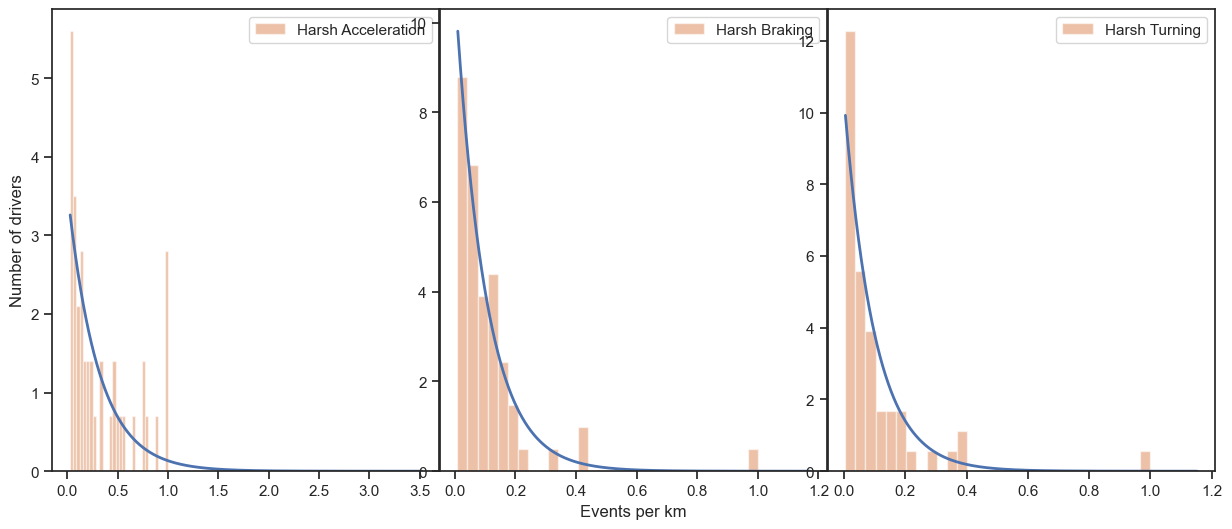

In [50]:
## Plot each fitted distribution

import matplotlib.pyplot as plt
import scipy.stats as st

DIST = st.expon

def create_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## fit exponential distribution
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in normalizedFeatures:
    print(col)
    feature = normalizedFeatures[col]
    x = feature.values[feature.values > 0] # only fit positive values to keep the distribution tighter
   
    params = DIST.fit(x)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   
    #Plot
    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    
    #Plot
    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    ## Calculate SSE
    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per km')
axs[0].set_ylabel('Number of drivers')

    

#### Create a single metric
The commulative metric is the sum (or weighted sum) of CDFs per event type. here we assume that features have equal weights.

In [51]:
def calculate_joint_score(perFeatureScores):
    driverScores = perFeatureScores
    featureCols = [col for col in driverScores if col.startswith('Harsh')]
    driverScores['metric'] = (driverScores[featureCols].sum(axis = 1) / 3.0)
    driverScores = driverScores.sort_values('metric')
    driverScores['rank'] = (driverScores.metric.rank(method="min")-1)/((len(perFeatureScores)-1)*1.0)
    return driverScores

driverScores = calculate_joint_score(perFeatureScores)

Since the entire population won't be available on test time, we fit a simple linear model to find the relation between the metric (weighted sum of CDFs) and the rank (the position in the population). We will use the metric value at test time, and this model to estimate the driver's hypothetical rank in this population. Since we are doing in-population analysis, and this is a very simple model, there's no need for train/test split.

In [52]:
from sklearn.linear_model import LinearRegression

def get_linear_model(perFeatureScores):
    driverScores = calculate_joint_score(perFeatureScores)
    reg = LinearRegression()
    x = driverScores['metric'].values.reshape(-1, 1)
    y = driverScores['rank'].values.reshape(-1, 1)
    reg.fit(x, y)
    return reg

def get_rank(regModel, metric):
    # Convert the metric to 2D array before prediction
    metric = np.array(metric).reshape(-1, 1)
    rank = regModel.predict(metric)
    
    # Clip the rank between 0 and 1
    rank = np.clip(rank, 0, 1)
    
    # Return as scalar
    return rank.item()

regModel = get_linear_model(perFeatureScores)
sampleRank = get_rank(regModel, 0.5)
sampleRank

0.6945107656258922

In [53]:
## Top 10 safest drivers?
driverScores.head(10)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF,metric,rank
6,0.0000,0.0000,0.0000,0.0000,0.0000
27,0.0000,0.0000,0.0000,0.0000,0.0000
29,0.0000,0.0000,0.0000,0.0000,0.0000
20,0.0000,0.0000,0.0000,0.0000,0.0000
25,0.0000,0.0000,0.0000,0.0000,0.0000
51,0.0000,0.0000,0.0000,0.0000,0.0000
47,0.0000,0.0000,0.0000,0.0000,0.0000
32,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.0000,0.0000,0.0000,0.0000,0.0000
70,0.0000,0.0000,0.0000,0.0000,0.0000


In [54]:
## top 10 most risky drivers?
driverScores.tail(10)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF,metric,rank
39,0.0597,0.9814,0.8592,0.6334,0.8767
59,0.7542,0.4614,0.8925,0.7027,0.8904
44,0.9596,0.2901,1.0000,0.7499,0.9041
42,0.8186,0.8951,0.6245,0.7794,0.9178
72,0.8373,0.6875,0.8155,0.7801,0.9315
48,0.9596,0.7662,0.6328,0.7862,0.9452
7,0.9421,0.7009,0.7955,0.8128,0.9589
37,0.4886,0.9845,0.9724,0.8152,0.9726
16,0.9074,0.7545,0.8277,0.8299,0.9863
15,0.9596,0.5765,0.9756,0.8372,1.0000


## Distributions of CDFs, rank and metric values

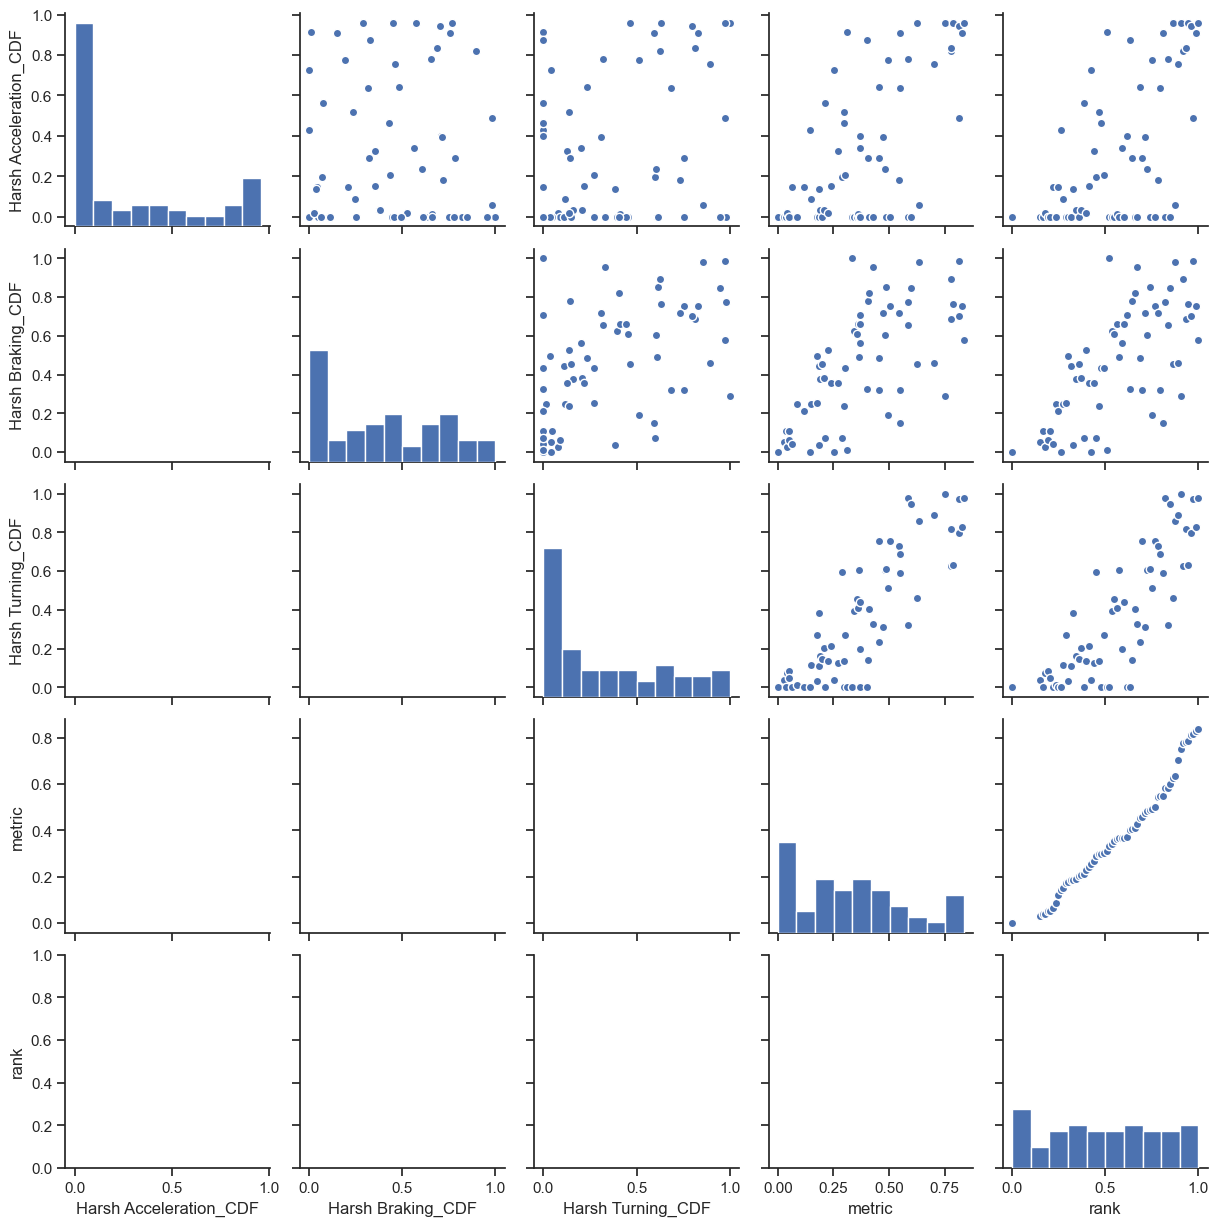

In [55]:
import seaborn as sns
sns.set(style="ticks")
g = sns.PairGrid(driverScores)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

### Estimating safety for an arbitrary subscriber
The following process estimates the score of a new driver:
1. Calculate features - number of events per km
2. Calculate CDFs by estimating the CDF per feature value using the fitted functions during 'training'. We use the function's parameters to estimate the CDF per new value.
3. Calculate the weighted sum metric. The value of this metric corresponds to the point in the population this new driver resides in.
4. Calculate a rank within a population

In [56]:
safeDriver = [{'Harsh Acceleration':0.005,
                       'Harsh Braking':0.005,
                       'Harsh Turning':0.005}]

riskyDriver = [{'Harsh Acceleration':0.2,
                       'Harsh Braking':0.16,
                       'Harsh Turning':0.28}]

safeDriverDf = pd.DataFrame(safeDriver,index = None)
riskyDriverDf = pd.DataFrame(riskyDriver,index = None)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams,minPerFeature,maxPerFeature):

    normalized = (driverDf - minPerFeature) / (maxPerFeature - minPerFeature)
    scoreDF = pd.DataFrame()
    for col in normalized:
        scoreDF[col] = calculate_score_for_series(normalized[col],fittedParams,True)
    scoreDF = calculate_joint_score(scoreDF)
    return scoreDF


safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams,minPerFeature,maxPerFeature)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams,minPerFeature,maxPerFeature)

safeDriverMetric = safeDriverWithMetric['metric'].values[0]
riskyDriverMetric = riskyDriverWithMetric['metric'].values[0]


print('------')
print("Rank for safe driver = {}".format(get_rank(regModel,safeDriverMetric)))
print("Metric for safe driver = {}".format(safeDriverMetric))
print('------')
print("Rank for risky driver = {}".format(get_rank(regModel,riskyDriverMetric)))
print("Metric for risky driver = {}".format(riskyDriverMetric))


****** Estimated safety scores ******
Calculating scores for feature: Harsh Acceleration
   Event value  Event probability
0       0.5536             0.8243
Calculating scores for feature: Harsh Braking
   Event value  Event probability
0       0.0484             0.3258
Calculating scores for feature: Harsh Turning
   Event value  Event probability
0       0.0408             0.3102
Calculating scores for feature: Harsh Acceleration
   Event value  Event probability
0      22.1445             1.0000
Calculating scores for feature: Harsh Braking
   Event value  Event probability
0       1.5473             1.0000
Calculating scores for feature: Harsh Turning
   Event value  Event probability
0       2.2839             1.0000
------
Rank for safe driver = 0.6785888714560946
Metric for safe driver = 0.4867579625382504
------
Rank for risky driver = 1.0
Metric for risky driver = 0.9999999200873383


There are two alternatives here for results: the metric (weighted sum), which gives a score with regards to the amount of events of each type, and the rank, which shows on which percentile of the population the driver is. Depending on the use case, one can decide on the right metric.
Since the relation between these two metrics is not 100% linear, we get different results than the training set. In this case we get a rank of 0.28 and metric of 0.15 for a driver with almost 0 events.

# Deployment on a Spark cluster
The PySpark code is very similar to the pandas code. It performs the feature calculation and normalization on a spark cluster, where each driver's data is computed separately. Then it aggregates the data into one node and performs the population statistics on this node. This process is utilized for each segment in the population, where segments are groups of drivers with similar attributes (e.g. same type of vehicle, same country, same device installed, same device firmware/software).

For the PySpark version of this analysis, open [this notebook](Driver safety estimation - pyspark.ipynb)